In [7]:
import pandas as pd
import zipfile
import os

# === Set up paths ===
base_path = "input_data1/"
output_path = "cleaned_data/"
os.makedirs(output_path, exist_ok=True)

# === Step 1: Unzip files ===
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_file(base_path + "hmda_2007_nationwide_first-lien-owner-occupied-1-4-family-records_labels.zip", base_path + "2007_data/")
unzip_file(base_path + "hmda_2017_nationwide_first-lien-owner-occupied-1-4-family-records_labels (1).zip", base_path + "2017_data/")
unzip_file(base_path + "2023_combined_mlar.zip", base_path + "2023_data/")

# === Step 2: Chunked processing for 2007/2017 ===
def process_hmda_file(folder, output_filename, year, delimiter, state_codes):
    chunk_size = 100000
    first_chunk = True
    columns_to_keep = [
        'year', 'state_code', 'county_code', 'census_tract_number',
        'loan_amount_000s', 'applicant_income_000s',
        'property_value', 'loan_purpose', 'lien_status'
    ]

    for file in os.listdir(folder):
        if file.endswith(".csv") or file.endswith(".txt"):
            path = os.path.join(folder, file)
            break

    for chunk in pd.read_csv(path, sep=delimiter, chunksize=chunk_size, low_memory=False):
        chunk.columns = [col.strip().lower() for col in chunk.columns]
        if 'state_code' not in chunk.columns:
            continue
        chunk = chunk[chunk['state_code'].astype(str).isin(state_codes)]
        filters = (
            (chunk['loan_type'] == 1) if 'loan_type' in chunk.columns else True
        ) & (
            (chunk['property_type'] == 1) if 'property_type' in chunk.columns else True
        ) & (
            (chunk.get('owner_occupancy', chunk.get('occupancy')) == 1)
        ) & (
            (chunk['action_taken'] == 1) if 'action_taken' in chunk.columns else True
        )
        chunk = chunk[filters]
        tract_field = 'census_tract_number' if 'census_tract_number' in chunk.columns else 'census_tract'
        chunk = chunk.dropna(subset=[tract_field, 'loan_amount_000s', 'applicant_income_000s'])
        chunk['year'] = year
        chunk = chunk.rename(columns={tract_field: 'census_tract'})
        existing_cols = [col for col in columns_to_keep if col in chunk.columns]
        chunk = chunk[existing_cols]
        chunk.to_csv(os.path.join(output_path, output_filename), mode='a', index=False, header=first_chunk)
        first_chunk = False

    print(f"Finished {year}: saved to cleaned_data/{output_filename}")

# === Step 3: Special handling for 2023 data ===
def process_2023_file(folder, output_filename):
    chunk_size = 100000
    first_chunk = True
    colnames = [
        "as_of_year", "lei", "loan_type", "property_type", "loan_purpose", "occupancy", 
        "preapproval", "loan_amount", "action_taken", "state_abbr", "county_code", "census_tract"
    ]
    for file in os.listdir(folder):
        if file.endswith(".csv") or file.endswith(".txt"):
            path = os.path.join(folder, file)
            break

    for chunk in pd.read_csv(path, sep="|", chunksize=chunk_size, header=None, low_memory=False):
        sub = chunk.iloc[:, :12].copy()
        sub.columns = colnames
        sub = sub[sub['state_abbr'].isin(['FL', 'TX'])]
        sub = sub[
            (sub['loan_type'] == 1) &
            (sub['property_type'] == 1) &
            (sub['occupancy'] == 1) &
            (sub['action_taken'] == 1)
        ]
        sub = sub.dropna(subset=['loan_amount', 'census_tract', 'county_code'])
        sub['year'] = 2023
        sub.rename(columns={'loan_amount': 'loan_amount_000s'}, inplace=True)
        sub = sub[['year', 'state_abbr', 'county_code', 'census_tract', 'loan_amount_000s']]
        sub.to_csv(os.path.join(output_path, output_filename), mode='a', index=False, header=first_chunk)
        first_chunk = False

    print(f"Finished 2023: saved to cleaned_data/{output_filename}")

# === Step 4: Run All ===
state_codes = ['12', '48']
process_hmda_file(base_path + "2007_data/", "cleaned_2007_FL_TX.csv", 2007, ",", state_codes)
process_hmda_file(base_path + "2017_data/", "cleaned_2017_FL_TX.csv", 2017, ",", state_codes)
process_2023_file(base_path + "2023_data/", "cleaned_2023_FL_TX.csv")

print("🎉 All files processed and saved in cleaned_data/")

✅ Finished 2007: saved to cleaned_data/cleaned_2007_FL_TX.csv
✅ Finished 2017: saved to cleaned_data/cleaned_2017_FL_TX.csv
✅ Finished 2023: saved to cleaned_data/cleaned_2023_FL_TX.csv
🎉 All files processed and saved in cleaned_data/


In [34]:
import geopandas as gpd
import pandas as pd
import zipfile
import os
from shapely.geometry import Point

# === Step 1: Unzip shapefiles ===
def unzip_shapefile(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_shapefile("input_data1/tl_2023_12_tract.zip", "input_data1/shapefiles/fl/")
unzip_shapefile("input_data1/tl_2023_48_tract.zip", "input_data1/shapefiles/tx/")

# === Step 2: Load shapefiles as GeoDataFrames ===
gdf_fl = gpd.read_file("input_data1/shapefiles/fl")
gdf_tx = gpd.read_file("input_data1/shapefiles/tx")

# === Step 3: Combine and calculate centroids ===
gdf_combined = pd.concat([gdf_fl, gdf_tx], ignore_index=True)
gdf_combined = gdf_combined[["GEOID", "geometry"]].copy()

# Optional: fix centroid CRS warning (reproject to Web Mercator)
gdf_combined = gdf_combined.to_crs(epsg=3857)

gdf_combined_proj = gdf_combined.to_crs(epsg=3857)  # Web Mercator projection
gdf_combined["centroid"] = gdf_combined_proj.geometry.centroid
gdf_combined["lat"] = gdf_combined["centroid"].y
gdf_combined["lon"] = gdf_combined["centroid"].x
gdf_combined["lat"] = gdf_combined.centroid.y
gdf_combined["lon"] = gdf_combined.centroid.x
gdf_combined.drop(columns=["geometry", "centroid"], inplace=True)

# === Step 4: Save tract-to-coordinates lookup table ===
gdf_combined.to_csv("input_data1/tract_latlon_lookup.csv", index=False)
print("Tract centroid coordinates saved to input_data1/tract_latlon_lookup.csv")

# === Step 5: Merge lookup with HMDA data ===
for year in [2007, 2017, 2023]:
    fpath = f"cleaned_data/cleaned_{year}_FL_TX.csv"
    if not os.path.exists(fpath):
        print(f"Skipped {year}: file not found at {fpath}")
        continue

    df = pd.read_csv(fpath)

    # Identify correct census tract column
    tract_field = None
    for candidate in ['census_tract', 'census_tract_number']:
        if candidate in df.columns:
            tract_field = candidate
            break

    if tract_field is None:
        print(f"Skipped {year}: no usable tract column")
        continue

    df[tract_field] = df[tract_field].astype(str).str.zfill(11)
    df = df.merge(gdf_combined, how='left', left_on=tract_field, right_on='GEOID')
    df.to_csv(f"cleaned_data/geo_cleaned_{year}_FL_TX.csv", index=False)
    print(f"Merged tract coords with {year} and saved to geo_cleaned_{year}_FL_TX.csv")

Tract centroid coordinates saved to input_data1/tract_latlon_lookup.csv
Skipped 2007: no usable tract column
Skipped 2017: no usable tract column
Merged tract coords with 2023 and saved to geo_cleaned_2023_FL_TX.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422669 entries, 0 to 422668
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   year              422669 non-null  int64  
 1   state_abbr        422669 non-null  object 
 2   county_code       422669 non-null  float64
 3   census_tract      422669 non-null  float64
 4   loan_amount_000s  422669 non-null  int64  
 5   GEOID             0 non-null       float64
 6   lat               0 non-null       float64
 7   lon               0 non-null       float64
dtypes: float64(5), int64(2), object(1)
memory usage: 25.8+ MB
None
           year    county_code  census_tract  loan_amount_000s  GEOID  lat  \
count  422669.0  422669.000000  4.226690e+05      4.226690e+05    0.0  0.0   
mean     2023.0   30548.607352  3.054876e+10      4.001020e+05    NaN  NaN   
std         0.0   18075.570398  1.807566e+10      9.801601e+05    NaN  NaN   
min      2023.0   12001.000000

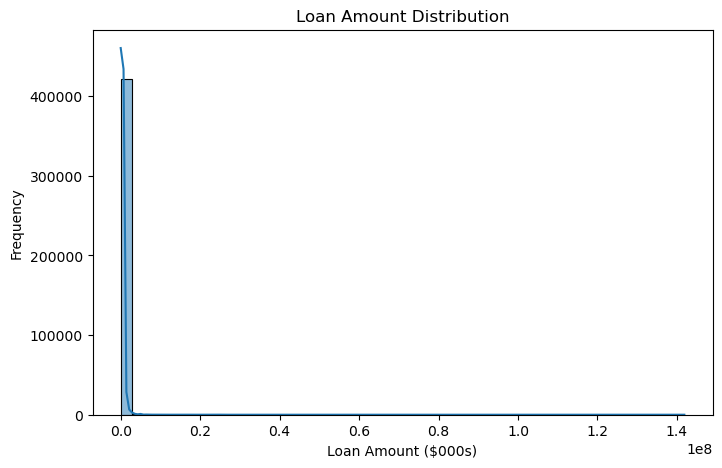

county_code
12087.0    865948.051948
48433.0    845000.000000
12131.0    791333.158722
48259.0    645365.630713
48299.0    624360.902256
Name: loan_amount_000s, dtype: float64


/var/folders/h6/655zg1890sg4l1s1rk51_cz00000gn/T/ipykernel_4685/714588105.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Loan ($000s)", loc="lower right")


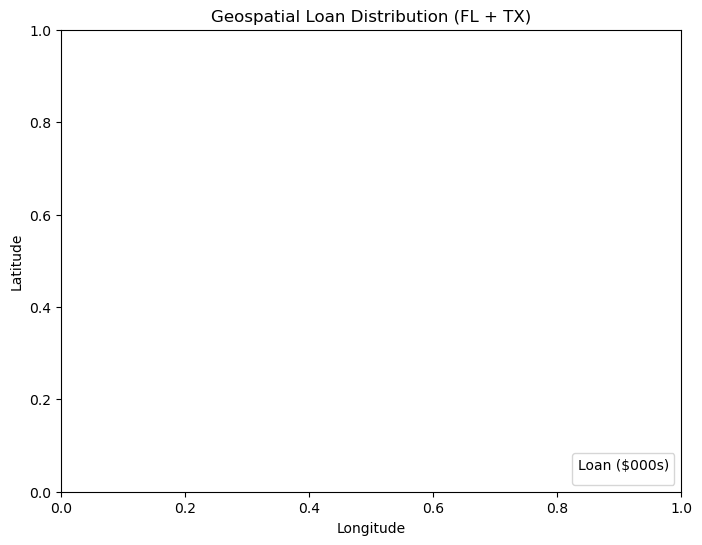

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_data/geo_cleaned_2023_FL_TX.csv")

# Basic info
print(df.info())
print(df.describe())

# Missing data check
print(df.isnull().sum())

# Distribution of loan amounts
plt.figure(figsize=(8, 5))
sns.histplot(df['loan_amount_000s'], bins=50, kde=True)
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount ($000s)")
plt.ylabel("Frequency")
plt.show()

# Average loan size by county
avg_by_county = df.groupby('county_code')['loan_amount_000s'].mean().sort_values(ascending=False)
print(avg_by_county.head())

# Plot lat/lon to preview mapping
plt.figure(figsize=(8, 6))
sns.scatterplot(x="lon", y="lat", data=df, hue="loan_amount_000s", palette="viridis", alpha=0.6)
plt.title("Geospatial Loan Distribution (FL + TX)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Loan ($000s)", loc="lower right")
plt.show()


In [ ]:
Final_Project/
├── cleaned_data/
│   ├── geo_cleaned_2023_FL_TX.csv
│   ├── cleaned_2007_FL_TX.csv
│   ├── cleaned_2017_FL_TX.csv
├── input_data1/
│   ├── hmda_*.zip (raw HMDA files)
│   ├── tl_2023_12_tract.zip
│   ├── tl_2023_48_tract.zip
│   ├── shapefiles/
│       ├── fl/
│       ├── tx/
│   ├── tract_latlon_lookup.csv
├── notebooks/
│   ├── `project_data_and_eda.ipynb`   ← ⬅️ MOVE YOUR CURRENT WORK HERE
├── scripts/
│   ├── clean_hmda_data.py
│   ├── add_latlon_from_tracts.py
├── README.md